In [749]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn

import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from mtcnn import MTCNN
import random

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [750]:
# GLOBAL VARS
preprocess = False
check_valid_img = False
train_adapter = False
add_features_flag = False
training_size_perc = 0.2
emotion_categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [751]:
# Directories
script_dir = os.getcwd()
findingemo_dir = os.path.join(script_dir, "../data/findingemo")
labels_dir = os.path.join(findingemo_dir, "labels")
base_dir = os.path.dirname(script_dir)
data_dir = os.path.join(base_dir, "data")

scene_feature365_dir = os.path.join(base_dir, "data", "findingemo", "precomputed", "scenes")
faces_feature_dir = os.path.join(base_dir, "data", "findingemo", "precomputed", "faces")
scene_feature7_dir = os.path.join(base_dir, "data", "findingemo", "precomputed", "scene_logits7")

In [752]:
face_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model.eval()

for p in face_model.parameters():
    p.requires_grad = False   # frozen

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 1707.08it/s]


In [753]:
class GateMLP(nn.Module):
    def __init__(self, in_dim, hidden=64, out_dim=4, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, out_dim)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return torch.softmax(self.net(x), dim=-1)


In [754]:
gate_net = GateMLP(in_dim=12, hidden=64, out_dim=4)

In [755]:
# Paths
csv_path = os.path.join(labels_dir, "annotations_cleaned.csv")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Emotion mapping (FindingEmo → 7 basic emotions)
FindingEmo_to_basic = {
    "Anger": 0, "Rage": 0, "Annoyance": 0,
    "Loathing": 1, "Disgust": 1,
    "Apprehension": 2, "Fear": 2, "Terror": 2,
    "Joy": 3, "Serenity": 3, "Ecstasy": 3, "Admiration": 3,
    "Grief": 4, "Sadness": 4, "Pensiveness": 4,
    "Amazement": 5, "Surprise": 5,
    "Trust": 6, "Interest": 6, "Boredom": 6, "Acceptance": 6, "Distraction": 6
}

# Load CSV
df = pd.read_csv(csv_path)
df["idx_emotion"] = df["emotion"].map(FindingEmo_to_basic)
df = df.dropna(subset=["idx_emotion"]).reset_index(drop=True)
df["idx_emotion"] = df["idx_emotion"].astype(int)

In [756]:
def is_image_valid(row):
    """Check if an image can be loaded without errors"""
    img_path = os.path.join(findingemo_dir, row['image_path'])
    
    if not os.path.exists(img_path):
        return False
    
    try:
        # Try loading with PIL (simpler)
        img = Image.open(img_path).convert("RGB")
        return True
    except Exception:
        return False

if check_valid_img:
    # Filter out invalid images
    print(f"Original dataset size: {len(df)}")
    valid_mask = df.apply(is_image_valid, axis=1)
    df_clean = df[valid_mask].reset_index(drop=True)
    print(f"Clean dataset size: {len(df_clean)}")
    print(f"Removed {len(df) - len(df_clean)} corrupted images")

    # Save the cleaned dataframe, overwriting the original
    df_clean.to_csv(csv_path, index=False)
    print(f"Saved cleaned dataset to: {csv_path}")

    # Update your main dataframe
    df = df_clean

# Now create train/test splits with clean data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [757]:
scene_tf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model.load_state_dict(state_dict)
scene_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scene_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [758]:
def preprocess_scene_logits(save_dir, subset):
    save_dir = os.path.join(save_dir, subset)

    if subset == "train":
        data = train_df
    else:
        data = test_df

    with torch.no_grad():
        for i, row in tqdm(data.iterrows(), total=len(data)):
            img_path = os.path.join(findingemo_dir, row['image_path'])
            if not os.path.exists(img_path):
                continue
            try:
                img = Image.open(img_path).convert("RGB")
                x = scene_tf(img).unsqueeze(0).to(device)
                logits = scene_model(x).squeeze(0).cpu()
                torch.save(logits, os.path.join(save_dir, f"{i}.pt"))
            except Exception as e:
                print(f"Error processing on index {i} on the {subset} set. Path: {img_path}: {e}")
                continue

if preprocess:
    preprocess_scene_logits(save_dir=scene_feature365_dir, subset="train")
    preprocess_scene_logits(save_dir=scene_feature365_dir, subset="test")

In [759]:
# Load category names
scene_categories_path = os.path.join(script_dir, "../data/places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print(scene_categories)

['airfield', 'airplane_cabin', 'airport_terminal', 'alcove', 'alley', 'amphitheater', 'amusement_arcade', 'amusement_park', 'apartment_building_outdoor', 'aquarium', 'aqueduct', 'arcade', 'arch', 'archaelogical_excavation', 'archive', 'arena_hockey', 'arena_performance', 'arena_rodeo', 'army_base', 'art_gallery', 'art_school', 'art_studio', 'artists_loft', 'assembly_line', 'athletic_field_outdoor', 'atrium_public', 'attic', 'auditorium', 'auto_factory', 'auto_showroom', 'badlands', 'bakery_shop', 'balcony_exterior', 'balcony_interior', 'ball_pit', 'ballroom', 'bamboo_forest', 'bank_vault', 'banquet_hall', 'bar', 'barn', 'barndoor', 'baseball_field', 'basement', 'basketball_court_indoor', 'bathroom', 'bazaar_indoor', 'bazaar_outdoor', 'beach', 'beach_house', 'beauty_salon', 'bedchamber', 'bedroom', 'beer_garden', 'beer_hall', 'berth', 'biology_laboratory', 'boardwalk', 'boat_deck', 'boathouse', 'bookstore', 'booth_indoor', 'botanical_garden', 'bow_window_indoor', 'bowling_alley', 'boxin

In [760]:
places365_to_13categories = {
    # --- Transport infrastructure ---
    "airfield": "transport_infrastructure",
    "airplane_cabin": "transport_infrastructure",
    "airport_terminal": "transport_infrastructure",
    "railroad_track": "transport_infrastructure",
    "train_interior": "transport_infrastructure",
    "train_station_platform": "transport_infrastructure",
    "subway_station_platform": "transport_infrastructure",
    "bridge": "transport_infrastructure",
    "runway": "transport_infrastructure",
    "highway": "transport_infrastructure",
    "garage_indoor": "transport_infrastructure",
    "garage_outdoor": "transport_infrastructure",
    "bus_interior": "transport_infrastructure",
    "bus_station_indoor": "transport_infrastructure",
    "harbor": "transport_infrastructure",
    "viaduct": "transport_infrastructure",
    "heliport": "transport_infrastructure",
    "parking_garage_indoor": "transport_infrastructure",
    "parking_garage_outdoor": "transport_infrastructure",
    "car_interior": "transport_infrastructure",
    "cockpit": "transport_infrastructure",
    "berth": "transport_infrastructure",

    # --- Indoor residential ---
    "bedroom": "indoor_residential",
    "bathroom": "indoor_residential",
    "living_room": "indoor_residential",
    "kitchen": "indoor_residential",
    "attic": "indoor_residential",
    "childs_room": "indoor_residential",
    "closet": "indoor_residential",
    "dining_room": "indoor_residential",
    "dorm_room": "indoor_residential",
    "hotel_room": "indoor_residential",
    "mansion": "indoor_residential",
    "nursery": "indoor_residential",
    "television_room": "indoor_residential",
    "pantry": "indoor_residential",
    "playroom": "indoor_residential",
    "house": "indoor_residential",
    "apartment_building_outdoor": "indoor_residential",
    "balcony_interior": "indoor_residential",
    "banquet_hall": "indoor_residential",
    "porch": "indoor_residential",
    "jacuzzi_indoor": "indoor_residential",
    "shower": "indoor_residential",
    "alcove": "indoor_residential",
    "bedchamber": "indoor_residential",
    "ballroom": "indoor_residential",
    "basement": "indoor_residential",
    "dressing_room": "indoor_residential",
    "home_office": "indoor_residential",
    "home_theater": "indoor_residential",
    "manufactured_home": "indoor_residential",
    "utility_room": "indoor_residential",
    "wet_bar": "indoor_residential",
    "youth_hostel": "indoor_residential",

    # --- Indoor commercial ---
    "bakery_shop": "indoor_commercial",
    "bar": "indoor_commercial",
    "bookstore": "indoor_commercial",
    "butchers_shop": "indoor_commercial",
    "candy_store": "indoor_commercial",
    "clothing_store": "indoor_commercial",
    "department_store": "indoor_commercial",
    "fastfood_restaurant": "indoor_commercial",
    "florist_shop_indoor": "indoor_commercial",
    "gift_shop": "indoor_commercial",
    "jewelry_shop": "indoor_commercial",
    "market_indoor": "indoor_commercial",
    "pet_shop": "indoor_commercial",
    "pharmacy": "indoor_commercial",
    "shoe_shop": "indoor_commercial",
    "shopping_mall_indoor": "indoor_commercial",
    "supermarket": "indoor_commercial",
    "toyshop": "indoor_commercial",
    "restaurant": "indoor_commercial",
    "restaurant_kitchen": "indoor_commercial",
    "restaurant_patio": "indoor_commercial",
    "pizzeria": "indoor_commercial",
    "pub_indoor": "indoor_commercial",
    "sushi_bar": "indoor_commercial",
    "hotel_outdoor": "indoor_commercial",
    "amusement_arcade": "indoor_commercial",
    "auto_showroom": "indoor_commercial",
    "bakery_shop": "indoor_commercial",
    "bank_vault": "indoor_commercial",
    "bazaar_indoor": "indoor_commercial",
    "beauty_salon": "indoor_commercial",
    "cafeteria": "indoor_commercial",
    "coffee_shop": "indoor_commercial",
    "delicatessen": "indoor_commercial",
    "discotheque": "indoor_commercial",
    "drugstore": "indoor_commercial",
    "fabric_store": "indoor_commercial",
    "flea_market_indoor": "indoor_commercial",
    "food_court": "indoor_commercial",
    "hardware_store": "indoor_commercial",
    "laundromat": "indoor_commercial",
    "market_outdoor": "indoor_commercial",
    "motel": "indoor_commercial",
    "pub_indoor": "indoor_commercial",
    "sauna": "indoor_commercial",
    "server_room": "indoor_commercial",
    "shoe_shop": "indoor_commercial",
    "shopping_mall_indoor": "indoor_commercial",
    "supermarket": "indoor_commercial",
    "booth_indoor": "indoor_commercial",
    "ice_cream_parlor": "indoor_commercial",
    "general_store_indoor": "indoor_commercial",
    "general_store_outdoor": "indoor_commercial",
    "pavilion": "indoor_commercial",
    "ticket_booth": "indoor_commercial",

    # --- Indoor institutional ---
    "art_gallery": "indoor_institutional",
    "auditorium": "indoor_institutional",
    "church_indoor": "indoor_institutional",
    "classroom": "indoor_institutional",
    "conference_room": "indoor_institutional",
    "hospital": "indoor_institutional",
    "hospital_room": "indoor_institutional",
    "library_indoor": "indoor_institutional",
    "lecture_room": "indoor_institutional",
    "office": "indoor_institutional",
    "office_cubicles": "indoor_institutional",
    "schoolhouse": "indoor_institutional",
    "science_museum": "indoor_institutional",
    "nursing_home": "indoor_institutional",
    "reception": "indoor_institutional",
    "waiting_room": "indoor_institutional",
    "museum_indoor": "indoor_institutional",
    "biology_laboratory": "indoor_institutional",
    "chemistry_lab": "indoor_institutional",
    "clean_room": "indoor_institutional",
    "conference_center": "indoor_institutional",
    "courthouse": "indoor_institutional",
    "embassy": "indoor_institutional",
    "entrance_hall": "indoor_institutional",
    "elevator_lobby": "indoor_institutional",
    "elevator_shaft": "indoor_institutional",
    "elevator_door": "indoor_institutional",
    "escalator_indoor": "indoor_institutional",
    "hospital": "indoor_institutional",
    "kindergarden_classroom": "indoor_institutional",
    "legislative_chamber": "indoor_institutional",
    "library_outdoor": "indoor_institutional",
    "lobby": "indoor_institutional",
    "locker_room": "indoor_institutional",
    "operating_room": "indoor_institutional",
    "physics_laboratory": "indoor_institutional",
    "recreation_room": "indoor_institutional",
    "veterinarians_office": "indoor_institutional",
    "atrium_public": "indoor_institutional",
    "corridor": "indoor_institutional",
    "computer_room": "indoor_institutional",
    "mezzanine": "indoor_institutional",
    "office_building": "indoor_institutional",
    "jail_cell": "indoor_institutional",
    "storage_room": "indoor_institutional",

    # --- Industrial facilities ---
    "assembly_line": "industrial_facility",
    "auto_factory": "industrial_facility",
    "engine_room": "industrial_facility",
    "industrial_area": "industrial_facility",
    "oilrig": "industrial_facility",
    "construction_site": "industrial_facility",
    "army_base": "industrial_facility",
    "junkyard": "industrial_facility",
    "repair_shop": "industrial_facility",
    "loading_dock": "industrial_facility",
    "fire_station": "industrial_facility",
    "landing_deck": "industrial_facility",
    "construction_site": "industrial_facility",
    "gas_station": "industrial_facility",
    "hangar_indoor": "industrial_facility",
    "hangar_outdoor": "industrial_facility",
    "dam": "industrial_facility",
    "excavation": "industrial_facility",
    "fire_escape": "industrial_facility",
    "landfill": "industrial_facility",
    "lock_chamber": "industrial_facility",
    "trench": "industrial_facility",
    "shed": "industrial_facility",

    # --- Urban outdoor ---
    "alley": "urban_outdoor",
    "building_facade": "urban_outdoor",
    "courtyard": "urban_outdoor",
    "crosswalk": "urban_outdoor",
    "downtown": "urban_outdoor",
    "plaza": "urban_outdoor",
    "street": "urban_outdoor",
    "shopfront": "urban_outdoor",
    "parking_lot": "urban_outdoor",
    "residential_neighborhood": "urban_outdoor",
    "skyscraper": "urban_outdoor",
    "amusement_park": "urban_outdoor",
    "arcade": "urban_outdoor",
    "balcony_exterior": "urban_outdoor",
    "bazaar_outdoor": "urban_outdoor",
    "boardwalk": "urban_outdoor",
    "driveway": "urban_outdoor",
    "doorway_outdoor": "urban_outdoor",
    "gazebo_exterior": "urban_outdoor",
    "market_outdoor": "urban_outdoor",
    "patio": "urban_outdoor",
    "plaza": "urban_outdoor",
    "promenade": "urban_outdoor",
    "rope_bridge": "urban_outdoor",
    "street": "urban_outdoor",
    "tower": "urban_outdoor",
    "slum": "urban_outdoor",
    "sky": "urban_outdoor",
    "roof_garden": "urban_outdoor",
    "phone_booth": "urban_outdoor",

    # --- Natural landscapes ---
    "badlands": "natural_landscape",
    "canyon": "natural_landscape",
    "cliff": "natural_landscape",
    "desert_sand": "natural_landscape",
    "desert_vegetation": "natural_landscape",
    "forest_broadleaf": "natural_landscape",
    "forest_path": "natural_landscape",
    "mountain": "natural_landscape",
    "mountain_path": "natural_landscape",
    "mountain_snowy": "natural_landscape",
    "valley": "natural_landscape",
    "volcano": "natural_landscape",
    "rock_arch": "natural_landscape",
    "rainforest": "natural_landscape",
    "bamboo_forest": "natural_landscape",
    "butte": "natural_landscape",
    "canal_natural": "natural_landscape",
    "cliff": "natural_landscape",
    "coast": "natural_landscape",
    "creek": "natural_landscape",
    "crevasse": "natural_landscape",
    "desert_road": "natural_landscape",
    "field_road": "natural_landscape",
    "forest_road": "natural_landscape",
    "grotto": "natural_landscape",
    "islet": "natural_landscape",
    "lawn": "natural_landscape",
    "marsh": "natural_landscape",
    "swamp": "natural_landscape",
    "vegetable_garden": "natural_landscape",
    "wheat_field": "natural_landscape",
    "wind_farm": "natural_landscape",
    "windmill": "natural_landscape",
    "zen_garden": "natural_landscape",
    "canal_urban": "natural_landscape",
    "fountain": "natural_landscape",

    # --- Cold environments ---
    "ice_floe": "cold_environment",
    "ice_shelf": "cold_environment",
    "iceberg": "cold_environment",
    "igloo": "cold_environment",
    "ski_resort": "cold_environment",
    "ski_slope": "cold_environment",
    "snowfield": "cold_environment",
    "tundra": "cold_environment",
    "glacier": "cold_environment",

    # --- Aquatic environments ---
    "aquarium": "aquatic_environment",
    "beach": "aquatic_environment",
    "boat_deck": "aquatic_environment",
    "boathouse": "aquatic_environment",
    "harbor": "aquatic_environment",
    "lake_natural": "aquatic_environment",
    "lagoon": "aquatic_environment",
    "ocean": "aquatic_environment",
    "pond": "aquatic_environment",
    "river": "aquatic_environment",
    "waterfall": "aquatic_environment",
    "swimming_pool_indoor": "aquatic_environment",
    "swimming_pool_outdoor": "aquatic_environment",
    "swimming_hole": "aquatic_environment",
    "hot_spring": "aquatic_environment",
    "beach_house": "aquatic_environment",
    "fishpond": "aquatic_environment",
    "moat_water": "aquatic_environment",
    "pier": "aquatic_environment",
    "raft": "aquatic_environment",
    "watering_hole": "aquatic_environment",
    "wave": "aquatic_environment",
    "water_tower": "aquatic_environment",
    "underwater_ocean_deep": "aquatic_environment",
    "lighthouse": "aquatic_environment",


    # --- Religious or historical sites ---
    "church_outdoor": "religious_or_historical_site",
    "mosque_outdoor": "religious_or_historical_site",
    "synagogue_outdoor": "religious_or_historical_site",
    "temple_asia": "religious_or_historical_site",
    "catacomb": "religious_or_historical_site",
    "mausoleum": "religious_or_historical_site",
    "palace": "religious_or_historical_site",
    "castle": "religious_or_historical_site",
    "ruin": "religious_or_historical_site",
    "arch": "religious_or_historical_site",
    "amphitheater": "religious_or_historical_site",
    "archaelogical_excavation": "religious_or_historical_site",
    "burial_chamber": "religious_or_historical_site",
    "cemetery": "religious_or_historical_site",
    "chalet": "religious_or_historical_site",
    "kasbah": "religious_or_historical_site",
    "medina": "religious_or_historical_site",
    "pagoda": "religious_or_historical_site",
    "throne_room": "religious_or_historical_site",

    # --- Sports and entertainment ---
    "arena_hockey": "sports_and_entertainment",
    "arena_performance": "sports_and_entertainment",
    "arena_rodeo": "sports_and_entertainment",
    "baseball_field": "sports_and_entertainment",
    "basketball_court_indoor": "sports_and_entertainment",
    "boxing_ring": "sports_and_entertainment",
    "football_field": "sports_and_entertainment",
    "gymnasium_indoor": "sports_and_entertainment",
    "martial_arts_gym": "sports_and_entertainment",
    "racecourse": "sports_and_entertainment",
    "stadium_football": "sports_and_entertainment",
    "stadium_soccer": "sports_and_entertainment",
    "stage_indoor": "sports_and_entertainment",
    "stage_outdoor": "sports_and_entertainment",
    "bowling_alley": "sports_and_entertainment",
    "movie_theater_indoor": "sports_and_entertainment",
    "amphitheater": "sports_and_entertainment",
    "athletic_field_outdoor": "sports_and_entertainment",
    "ball_pit": "sports_and_entertainment",
    "baseball_field": "sports_and_entertainment",
    "basketball_court_indoor": "sports_and_entertainment",
    "bow_window_indoor": "sports_and_entertainment",
    "boxing_ring": "sports_and_entertainment",
    "bullring": "sports_and_entertainment",
    "football_field": "sports_and_entertainment",
    "raceway": "sports_and_entertainment",
    "soccer_field": "sports_and_entertainment",
    "stadium_baseball": "sports_and_entertainment",
    "staircase": "sports_and_entertainment",
    "topiary_garden": "sports_and_entertainment",
    "water_park": "sports_and_entertainment",
    "carrousel": "sports_and_entertainment",
    "dining_hall": "sports_and_entertainment",
    "diner_outdoor": "sports_and_entertainment",
    "ice_skating_rink_indoor": "sports_and_entertainment",
    "ice_skating_rink_outdoor": "sports_and_entertainment",


    # --- Cultural spaces ---
    "art_studio": "cultural_space",
    "art_school": "cultural_space",
    "music_studio": "cultural_space",
    "television_studio": "cultural_space",
    "museum_outdoor": "cultural_space",
    "artists_loft": "cultural_space",
    "archive": "cultural_space",
    "galley": "cultural_space",
    "japanese_garden": "cultural_space",
    "natural_history_museum": "cultural_space",
    "music_studio": "cultural_space",
    "orchestra_pit": "cultural_space",

    # --- Rural or recreational area ---
    "aqueduct": "rural_or_recreational_area",
    "barn": "rural_or_recreational_area",
    "barndoor": "rural_or_recreational_area",
    "beer_garden": "rural_or_recreational_area",
    "beer_hall": "rural_or_recreational_area",
    "botanical_garden": "rural_or_recreational_area",
    "cabin_outdoor": "rural_or_recreational_area",
    "campsite": "rural_or_recreational_area",
    "campus": "rural_or_recreational_area",
    "farm": "rural_or_recreational_area",
    "field_cultivated": "rural_or_recreational_area",
    "field_wild": "rural_or_recreational_area",
    "golf_course": "rural_or_recreational_area",
    "greenhouse_outdoor": "rural_or_recreational_area",
    "hayfield": "rural_or_recreational_area",
    "orchard": "rural_or_recreational_area",
    "park": "rural_or_recreational_area",
    "pasture": "rural_or_recreational_area",
    "picnic_area": "rural_or_recreational_area",
    "playground": "rural_or_recreational_area",
    "rice_paddy": "rural_or_recreational_area",
    "sandbox": "rural_or_recreational_area",
    "stable": "rural_or_recreational_area",
    "tree_farm": "rural_or_recreational_area",
    "tree_house": "rural_or_recreational_area",
    "village": "rural_or_recreational_area",
    "vineyard": "rural_or_recreational_area",
    "volleyball_court_outdoor": "rural_or_recreational_area",
    "yard": "rural_or_recreational_area",
    "corn_field": "rural_or_recreational_area",
    "corral": "rural_or_recreational_area",
    "cottage": "rural_or_recreational_area",
    "formal_garden": "rural_or_recreational_area",
    "greenhouse_indoor": "rural_or_recreational_area",
    "hunting_lodge_outdoor": "rural_or_recreational_area",
    "inn_outdoor": "rural_or_recreational_area",
    "kennel_outdoor": "rural_or_recreational_area",
    "pavilion": "rural_or_recreational_area",
    "oast_house": "rural_or_recreational_area",
}


In [761]:
for place in places365_to_13categories:
    if place not in scene_categories:
        print(place)

In [762]:
# Print the items that are not in scene_categories
for scene in scene_categories:
    if scene not in places365_to_13categories:
        print(scene)

In [763]:
len(places365_to_13categories)

365

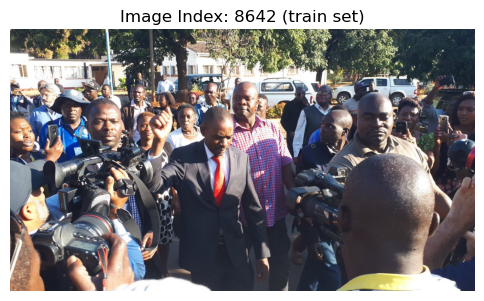

Top 5 scene categories for index 8642 in train set:
bazaar_outdoor: 21.61%
beer_garden: 21.56%
plaza: 17.55%
market_outdoor: 6.54%
bus_interior: 4.12%


In [764]:
def inspect_scene_logits(idx, subset):
    if subset == "train":
        data = train_df
    else:
        data = test_df

    logits_path = os.path.join(scene_feature365_dir, subset, f"{idx}.pt")
    if not os.path.exists(logits_path):
        print(f"Logits file does not exist: {logits_path}")
        return

    logits = torch.load(logits_path)
    top5_prob, top5_catid = torch.topk(torch.softmax(logits, dim=0), 5)

    # Display corresponding image
    img_path = os.path.join(findingemo_dir, data.loc[idx, 'image_path'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Image Index: {idx} ({subset} set)")
    plt.axis('off')
    plt.show()
    
    print(f"Top 5 scene categories for index {idx} in {subset} set:")
    for i in range(top5_prob.size(0)):
        print(f"{scene_categories[top5_catid[i]]}: {top5_prob[i].item()*100:.2f}%")

inspect_scene_logits(idx = random.randint(0, len(train_df) - 1), subset="train")
# inspect_scene_logits(idx = 0, subset="train")

In [765]:
# Get the shape of a scene tensor
tensor = torch.load(os.path.join(scene_feature365_dir,"train", "0.pt"))
print(tensor.shape)

torch.Size([365])


In [766]:
detector = MTCNN()
face_model = face_model.to(device)

def preprocess_face_logits(save_root, subset, base_findingemo_dir, max_faces = 3, starting_point = None):
    save_dir = os.path.join(save_root, subset)
    os.makedirs(save_dir, exist_ok=True)

    if subset == "train":
        data = train_df

    else:
        data = test_df

    if starting_point:
        data = data[starting_point:]

    for i, row in tqdm(data.iterrows(), total=len(data), desc=f"Processing {subset}"):
        img_path = os.path.join(base_findingemo_dir, row["image_path"].lstrip("/"))

        # check if the file already exists
        save_path = os.path.join(save_dir, f"{i}.pt")
        if os.path.exists(save_path) and torch.load(save_path).shape == (max_faces, 7):
            continue
        
        img = Image.open(img_path).convert("RGB")

        max_size = 2048  # Maximum dimension
        if max(img.size) > max_size:
            ratio = max_size / max(img.size)
            new_size = tuple(int(dim * ratio) for dim in img.size)
            img = img.resize(new_size, Image.Resampling.LANCZOS)
            print(f"Resized image {i} from large size to {new_size}")


        img_np = np.array(img)
        faces = detector.detect_faces(img_np)
        face_logits_list = []

        if faces:
            faces = sorted(faces, key=lambda f: f["box"][2] * f["box"][3], reverse=True)[:max_faces]
            crops = []
            for fdet in faces:
                x, y, w, h = fdet["box"]
                x, y = max(0, x), max(0, y)
                x2, y2 = min(img_np.shape[1], x + w), min(img_np.shape[0], y + h)
                crop = img_np[y:y2, x:x2]
                if crop.shape[0] < 10 or crop.shape[1] < 10:
                    continue
                face_tensor = face_processor(images=Image.fromarray(crop), return_tensors="pt")["pixel_values"].squeeze(0)
                crops.append(face_tensor)

            if crops:
                batch = torch.stack(crops).to(device)
                with torch.no_grad():
                    out = face_model(batch)
                    logits = out.logits.cpu()
                face_logits_list.extend(logits)

        while len(face_logits_list) < max_faces:
            face_logits_list.append(torch.zeros(7))

        stacked = torch.stack(face_logits_list[:max_faces])  # (3,7)
        torch.save(stacked, os.path.join(save_dir, f"{i}.pt"))

In [767]:
if preprocess:
    preprocess_face_logits("../data/findingemo/precomputed/faces", "train", findingemo_dir, 3, None)
    preprocess_face_logits("../data/findingemo/precomputed/faces", "test", findingemo_dir, 3, None)

In [768]:
def inspect_face_logits(idx, subset):
    if subset == "train":
        data = train_df
    else:
        data = test_df

    logits_path = os.path.join(script_dir, "../data/findingemo/precomputed/faces", subset, f"{idx}.pt")
    if not os.path.exists(logits_path):
        print(f"Logits file does not exist: {logits_path}")
        return

    logits = torch.load(logits_path)  # (max_faces, 7)

    # Display corresponding image
    img_path = os.path.join(findingemo_dir, data.loc[idx, 'image_path'].lstrip("/"))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Image Index: {idx} ({subset} set)")
    plt.axis('off')
    plt.show()
    
    print(f"Face emotion logits for index {idx} in {subset} set:")
    for i, logit in enumerate(logits):
        top3_prob, top3_catid = torch.topk(torch.softmax(logit, dim=0), 3)
        print(f"Face {i+1}:")
        for j in range(top3_prob.size(0)):
            emotion_label = emotion_categories[top3_catid[j].item()]
            print(f"  {emotion_label}: {top3_prob[j].item()*100:.2f}%")
        

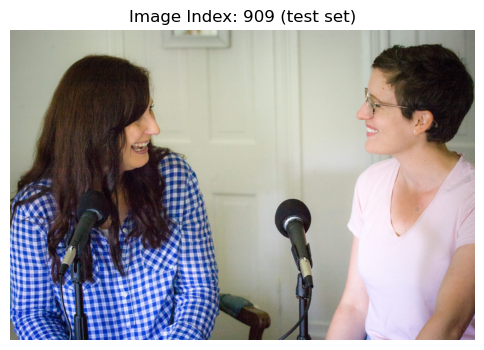

Face emotion logits for index 909 in test set:
Face 1:
  happy: 99.06%
  sad: 0.46%
  neutral: 0.23%
Face 2:
  fear: 36.69%
  angry: 24.87%
  surprise: 17.73%
Face 3:
  angry: 14.29%
  disgust: 14.29%
  fear: 14.29%


In [769]:
inspect_face_logits(idx = np.random.randint(0, len(test_df)), subset="test")

In [770]:
tensor = torch.load(os.path.join(faces_feature_dir,"train", "0.pt"))
print(tensor.shape)

torch.Size([3, 7])


In [771]:
# Dataset
class Scene365Dataset(Dataset):
    def __init__(self, df, feature_dir):
        self.df = df
        self.feature_dir = feature_dir
    def __getitem__(self, idx):
        x = torch.load(os.path.join(self.feature_dir, f"{idx}.pt"))  # (365,)
        y = torch.tensor(self.df.iloc[idx]["idx_emotion"], dtype=torch.long)
        return x, y
    def __len__(self):
        return len(self.df)

dataset = Scene365Dataset(train_df, scene_feature365_dir)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [772]:
# Small adapter: 365 → 64 → 7
class SceneAdapter(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(365, 64), nn.ReLU(),
            nn.Linear(64, 7)
        )
    def forward(self, x):
        return self.net(x)

adapter = SceneAdapter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
adapter.to(device)

SceneAdapter(
  (net): Sequential(
    (0): Linear(in_features=365, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [773]:
if train_adapter:
    optimizer = optim.Adam(adapter.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(20):
        adapter.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = adapter(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)
        print(f"Epoch {epoch+1}: Loss={total_loss/total:.4f}, Acc={correct/total:.3f}")

    torch.save(adapter.state_dict(), "scene_adapter_365to7.pth")
    print("Trained scene adapter saved.")

In [774]:
def show_adapter_predictions(idx, subset, model):
    if subset == "train":
        data = train_df
    else:
        data = test_df
    img_path = os.path.join(findingemo_dir, data.loc[idx, 'image_path'].lstrip("/"))
    img = Image.open(img_path).convert("RGB")
    
    logits_365 = torch.load(os.path.join(scene_feature365_dir, subset, f"{idx}.pt"))

    with torch.no_grad():
        logits_7 = model(logits_365.unsqueeze(0).to(device)).squeeze(0).cpu()

    probs = torch.softmax(logits_7, dim=0)
    top3_prob, top3_catid = torch.topk(probs, 3)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Image Index: {idx} (test set)")
    plt.axis('off')
    plt.show()

    print(f"Top 3 predicted emotions for index {idx} in test set:")
    for i in range(top3_prob.size(0)):
        emotion_label = emotion_categories[top3_catid[i].item()]
        print(f"{emotion_label}: {top3_prob[i].item()*100:.2f}%")

In [775]:
# Load the model and do a prediction for a random index and show the image and the prediction
adapter = SceneAdapter()
adapter.load_state_dict(torch.load("scene_adapter_365to7.pth"))
adapter.to(device)

SceneAdapter(
  (net): Sequential(
    (0): Linear(in_features=365, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
)

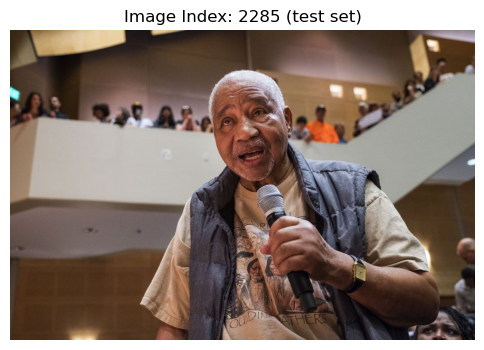

Top 3 predicted emotions for index 2285 in test set:
happy: 38.14%
angry: 24.80%
neutral: 17.72%


In [776]:
show_adapter_predictions(idx = np.random.randint(0, len(test_df)), subset="test", model=adapter)

In [777]:
# Presave adapter outputs
scene_feature7_train_dir = os.path.join(scene_feature7_dir, "train")
scene_feature7_test_dir = os.path.join(scene_feature7_dir, "test")

scene_feature365_train_dir = os.path.join(scene_feature365_dir, "train")
scene_feature365_test_dir = os.path.join(scene_feature365_dir, "test")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
adapter.eval()
adapter.to(device)

def save_scene_logits(df, feature_dir_365, save_dir):
    with torch.no_grad():
        for i in tqdm(range(len(df)), desc=f"Saving {save_dir}"):
            z365 = torch.load(os.path.join(feature_dir_365, f"{i}.pt"))  # (365,)
            z7 = adapter(z365.unsqueeze(0).to(device)).squeeze(0).cpu()  # (7,)
            torch.save(z7, os.path.join(save_dir, f"{i}.pt"))
            
if train_adapter:
    save_scene_logits(train_df, scene_feature365_train_dir, scene_feature7_train_dir)
    save_scene_logits(test_df,  scene_feature365_test_dir, scene_feature7_test_dir)
    print("Saved 7-D scene logits for DeepProbLog.")


In [778]:
tensor = torch.load(scene_feature7_train_dir + "/78.pt")
print(tensor.shape)

torch.Size([7])


In [779]:
def add_features(subset, threshold_scene_tag=0.3):
    if subset == "train":
        dataset = train_df
    else:
        dataset = test_df

    # Add faces_present tensor, scene_tag string and num_faces tensor to dataset
    faces_present_data = []
    num_faces_data = []
    scene_tag_data = []

    for i in range(len(dataset)):
        tensor_faces = torch.load(os.path.join(faces_feature_dir, subset, f"{i}.pt"))
        faces_present = []
        num_faces = 0

        for tensor in tensor_faces:
            faces_detected = not torch.all(tensor == 0)
            # If tensor is not all zeros, a face was detected
            if faces_detected:
                faces_present.append(1)
                num_faces += 1
            else:
                faces_present.append(0)
                
        faces_present_tensor = torch.tensor(faces_present)
        num_faces_tensor = torch.tensor([num_faces])

        faces_present_data.append(faces_present_tensor)
        num_faces_data.append(num_faces_tensor)

        tensor_scene = torch.load(os.path.join(scene_feature365_dir, subset, f"{i}.pt"))
        top_prob, top_catid = torch.topk(torch.softmax(tensor_scene, dim=0), 1)

        p = top_prob[0].item() 
        cat = scene_categories[top_catid[0].item()]
        mapped_cat = places365_to_13categories[cat]

        if p > threshold_scene_tag:
            scene_tag_data.append(mapped_cat)
        else:
            scene_tag_data.append("unknown")

        if i % 500 == 0:
            print(f"Processed {i} / {len(dataset)}")

    dataset['faces_present'] = faces_present_data
    dataset['num_faces'] = num_faces_data
    dataset['scene_tag'] = scene_tag_data

In [780]:
if add_features_flag:
    add_features("train")
    add_features("test")
    train_df.to_pickle(os.path.join(script_dir, "../data/findingemo/findingemo_train_with_features.pkl"))
    test_df.to_pickle(os.path.join(script_dir, "../data/findingemo/findingemo_test_with_features.pkl"))
    print("Saved datasets with added features.")

else:
    train_df = pd.read_pickle(os.path.join(script_dir, "../data/findingemo/findingemo_train_with_features.pkl"))
    test_df = pd.read_pickle(os.path.join(script_dir, "../data/findingemo/findingemo_test_with_features.pkl"))
    print("Loaded datasets with added features.")

Loaded datasets with added features.


In [781]:
train_df.head()

,image_path,valence,arousal,emotion,idx_emotion,faces_present,num_faces,scene_tag
0,Run_2/Raging people prison/23nutrage-web-super...,-2,3,Annoyance,0,"[tensor(1), tensor(1), tensor(1)]",[tensor(3)],indoor_institutional
1,Run_2/Grateful twenty-something film/5a19e334a...,0,1,Interest,6,"[tensor(1), tensor(1), tensor(1)]",[tensor(3)],unknown
2,Run_2/Violent twenty-something meeting/emmanue...,-3,6,Anger,0,"[tensor(1), tensor(1), tensor(0)]",[tensor(2)],urban_outdoor
3,Run_2/Awe twenty-something tennis/2-7-20-jazz.jpg,3,5,Joy,3,"[tensor(1), tensor(1), tensor(1)]",[tensor(3)],sports_and_entertainment
4,Run_1/Loving people rally/unite_the_right_rall...,1,6,Acceptance,6,"[tensor(1), tensor(1), tensor(1)]",[tensor(3)],unknown


In [782]:
train_df.iloc[0]["scene_tag"]

'indoor_institutional'

In [783]:
test_df.head()

,image_path,valence,arousal,emotion,idx_emotion,faces_present,num_faces,scene_tag
0,Run_2/Startled people protest/gettyimages-1152...,-2,5,Grief,4,"[tensor(1), tensor(1), tensor(1)]",[tensor(3)],industrial_facility
1,Run_2/Peaceful people office/1000x620.jpg,-3,5,Grief,4,"[tensor(1), tensor(1), tensor(1)]",[tensor(3)],indoor_institutional
2,Run_2/Violent soldiers kissing/200417_4153119_...,-2,3,Surprise,5,"[tensor(1), tensor(1), tensor(0)]",[tensor(2)],unknown
3,Run_2/Mocking students fighting/facebook.jpg,3,3,Acceptance,6,"[tensor(1), tensor(1), tensor(1)]",[tensor(3)],indoor_institutional
4,Run_2/Ashamed twenty-something school/5c75ff5f...,-2,1,Trust,6,"[tensor(1), tensor(1), tensor(1)]",[tensor(3)],sports_and_entertainment


In [784]:
class MoENet(nn.Module):
    def __init__(self, gate_net):
        super().__init__()
        self.gate_net  = gate_net

    def forward(self, z_face, z_scene, faces_present, num_faces):
        p_face  = torch.softmax(z_face, dim=-1)   # (B, 3, 7)
        p_face = p_face * faces_present.unsqueeze(-1)  # mask out missing ones
        p_scene = torch.softmax(z_scene, dim=-1)  # (B, 7)

        # Per-face max prob -> (B,3)
        max_face  = p_face.max(dim=-1).values

        # Per-face entropy -> (B,3)
        # H(p) = -sum_k p_k log p_k
        # Clamping is necessary to not have a probability of 0 inside the log. Otherwise NaNs appear.
        ent_face  = -(p_face.clamp_min(1e-12) * p_face.clamp_min(1e-12).log()).sum(dim=-1)

        # Scene max prob -> (B,)
        max_scene = p_scene.max(dim=-1).values

        # Scene entropy -> (B,)
        ent_scene = -(p_scene.clamp_min(1e-12) * p_scene.clamp_min(1e-12).log()).sum(dim=-1)

        # Shapes to concat along dim=-1:
        #   max_face:     (B,3)
        #   ent_face:     (B,3)
        #   max_scene:    (B,) -> unsqueeze -> (B,1)
        #   ent_scene:    (B,) -> unsqueeze -> (B,1)
        #   faces_present: (B,3)  (0/1 per face slot)
        #   num_faces:    (B,1)
        gate_feats = torch.cat([
            max_face,                       # (B,3)
            ent_face,                       # (B,3)
            max_scene.unsqueeze(-1),        # (B,1)
            ent_scene.unsqueeze(-1),        # (B,1)
            faces_present.float(),           # (B,3)
            num_faces.float()               # (B,1)
        ], dim=-1)                          # total per sample: 3+3+1+1+3+1 = 12 dims

        w = self.gate_net(gate_feats)       # (B,4)

        # Weighted mixture of the 4 expert distributions
        # p_face[:,0]: (B,7) = face0 distribution; etc.
        # p_scene:      (B,7) = scene distribution
        p_mix = (
            w[:,0].unsqueeze(-1) * p_face[:,0] +   # weight face 0
            w[:,1].unsqueeze(-1) * p_face[:,1] +   # weight face 1
            w[:,2].unsqueeze(-1) * p_face[:,2] +   # weight face 2
            w[:,3].unsqueeze(-1) * p_scene         # weight scene
        )
        # Normalize to ensure valid probability distribution sums to 1
        p_mix = p_mix / p_mix.sum(dim=-1, keepdim=True).clamp_min(1e-12)
        return p_mix                           # (B,7)

In [785]:
moe = MoENet(gate_net=gate_net)

# Test a forward pass with dummy data
z_scene = torch.load(os.path.join(scene_feature7_train_dir, "0.pt"))
z_face = torch.load(os.path.join(faces_feature_dir, "train", "0.pt"))

faces_present = train_df.loc[0, 'faces_present']
num_faces = train_df.loc[0, 'num_faces']

print("Scene logits:", z_scene)
print("Scene logits shape:", z_scene.shape)
print("Face logits:", z_face)
print("Face logits shape:", z_face.shape)
print("Faces present:", faces_present)
print("Num faces:", num_faces)
print("")
# get the types
print("scene logits type:", type(z_scene))
print("face logits type:", type(z_face))
print("faces_present type:", type(faces_present))
print("num_faces type:", type(num_faces))

Scene logits: tensor([ 0.1701, -1.9053, -0.8123,  0.9923, -0.0127, -1.5008,  0.9945])
Scene logits shape: torch.Size([7])
Face logits: tensor([[-2.2779, -2.0088,  0.1514, -1.2739,  2.6749,  2.3900, -1.8163],
        [-2.2620, -2.3936, -1.2500,  4.9283,  1.5020, -0.4002, -1.6560],
        [-0.2891, -1.9454,  0.2601, -0.7798, -1.1852,  4.2627, -1.7051]])
Face logits shape: torch.Size([3, 7])
Faces present: tensor([1, 1, 1])
Num faces: tensor([3])

scene logits type: <class 'torch.Tensor'>
face logits type: <class 'torch.Tensor'>
faces_present type: <class 'torch.Tensor'>
num_faces type: <class 'torch.Tensor'>


In [786]:
moe(z_face.unsqueeze(0), z_scene.unsqueeze(0), faces_present.unsqueeze(0), num_faces.unsqueeze(0))

tensor([[0.0090, 0.0021, 0.0131, 0.5165, 0.0752, 0.3712, 0.0130]],
       grad_fn=<DivBackward0>)

In [787]:
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant, Var
from deepproblog.query import Query
from deepproblog.train import train_model

from deepproblog.engines import ApproximateEngine, ExactEngine
from deepproblog.optimizer import SGD

In [788]:
class DiskTensorSource:
    """
    Minimal tensor source that DeepProbLog can call via:
       tensor(<name>, Key, T)
    We map Key (e.g., integer index) -> torch.Tensor
    """
    def __init__(self, root_dir):
        self.root = root_dir

    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)

        path = os.path.join(self.root, f"{index}.pt")
        t = torch.load(path)
        return t.detach().clone().float()

In [789]:
class DFColumnSource:
    def __init__(self, df, column):
        self.df = df
        self.col= column

    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        val = self.df.iloc[index][self.col]
        return val.detach().clone().float()

In [790]:
# Deepproblog Dataset
class FindingEmoDPL(Dataset, TorchDataset):
    def __init__(self, indices, df):
        super().__init__()
        self.indices = indices
        self.df = df

    def __len__(self):
        return len(self.indices)

    def to_query(self, i):
        idx = self.indices[i]
        scene_tag = self.df.iloc[idx]["scene_tag"]
        label     = int(self.df.iloc[idx]["idx_emotion"])

        # E is the variable DeepProbLog will predict
        E = Var("E")

        goal = Term("final_emo",
                    Term("tensor", Term(f"face_logits7", Constant(idx))), # F aces 
                    Term("tensor", Term(f"scene_logits7", Constant(idx))), # S cene
                    Term("tensor", Term(f"faces_present", Constant(idx))), # FP Faces Present
                    Term("tensor", Term(f"num_faces", Constant(idx))), # N Number of Faces
                    Constant(scene_tag),  # ST Scene Tag
                    E)                    # variable to predict

        # tell DeepProbLog which value of E is correct
        return Query(goal, substitution={E: Constant(label)})

In [791]:
moe_network = Network(moe, "moe_net", batching=True)

In [792]:
training_size = int(len(train_df) * training_size_perc)

train_indices = list(range(0, training_size))
test_indices = list(range(0, len(test_df)))

train_set = FindingEmoDPL(train_indices, train_df)
test_set  = FindingEmoDPL(test_indices, test_df)

In [793]:
model = Model(os.path.join(script_dir, "model.pl"), [moe_network])
model.set_engine(ExactEngine(model), cache=True)

Caching ACs


In [794]:
face_train_path = os.path.join(faces_feature_dir, "train")
face_test_path  = os.path.join(faces_feature_dir, "test")

scene_train_path = os.path.join(scene_feature7_dir, "train")
scene_test_path  = os.path.join(scene_feature7_dir, "test")

In [795]:
# When prolog asks for tensor("face_logits7", Key, T), it will be loaded thanks to the following code
model.add_tensor_source("face_logits7", DiskTensorSource(face_train_path))
model.add_tensor_source("scene_logits7", DiskTensorSource(scene_train_path))

# Add the metadata
model.add_tensor_source("faces_present", DFColumnSource(train_df, "faces_present"))
model.add_tensor_source("num_faces", DFColumnSource(train_df, "num_faces"))

In [804]:
res = model.solve([train_set.to_query(0)])
print(res[0])

{final_emo(tensor(face_logits7(0)),tensor(scene_logits7(0)),tensor(faces_present(0)),tensor(num_faces(0)),indoor_institutional,0): tensor(0.0031, grad_fn=<AddBackward0>), final_emo(tensor(face_logits7(0)),tensor(scene_logits7(0)),tensor(faces_present(0)),tensor(num_faces(0)),indoor_institutional,1): tensor(0.0006, grad_fn=<MulBackward0>), final_emo(tensor(face_logits7(0)),tensor(scene_logits7(0)),tensor(faces_present(0)),tensor(num_faces(0)),indoor_institutional,2): tensor(0.0022, grad_fn=<MulBackward0>), final_emo(tensor(face_logits7(0)),tensor(scene_logits7(0)),tensor(faces_present(0)),tensor(num_faces(0)),indoor_institutional,3): tensor(0.1285, grad_fn=<MulBackward0>), final_emo(tensor(face_logits7(0)),tensor(scene_logits7(0)),tensor(faces_present(0)),tensor(num_faces(0)),indoor_institutional,4): tensor(0.0128, grad_fn=<MulBackward0>), final_emo(tensor(face_logits7(0)),tensor(scene_logits7(0)),tensor(faces_present(0)),tensor(num_faces(0)),indoor_institutional,5): tensor(0.0696, grad

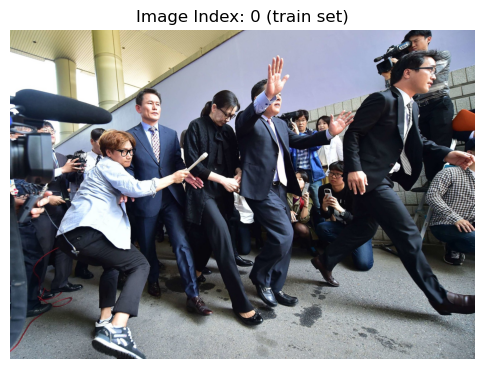

Top 5 scene categories for index 0 in train set:
nursing_home: 30.14%
gymnasium_indoor: 6.06%
campus: 4.84%
airport_terminal: 4.57%
television_studio: 3.73%


In [805]:
inspect_scene_logits(0, "train")